# Hussaini-lab-to-nwb - Data from Axona dacqUSB system

### File overview (input)

- General settings: `.set` file
- Raw signals: `.bin` file
    - Raw signals only around thresholded spike events: `.X` file
    - Animal position: `.pos` file
    
### The `TINT` file format (output)

Each tetrode has:
- `.X` = Waveforms for each channel and spike
- `.cut` = Unit label sequence for each spike
- `.clu` = Simplified `.cut` file
    
### Goals

1. Read `.bin` data into `neo`, then `spikeextractors`.
2. Read `.X` data into `spikeextractors`.
3. Create spike sorting pipeline in jupyter notebook for `.bin` or `.X` data.
4. Export spike sorting results from `spikeextractors` to `TINT` and `nwb` format.

## 1. Read `.bin` data into `neo`, then `spikeextractors`.

### Header
The header consists of:
* 4 bytes ID (will be "ADU1", unless the tracker position record is populated with valid data,
in which case it will be "ADU2")
* 4 bytes packet number
* 2 bytes digital inputs
* 2 bytes sync inputs
* 20 bytes tracker position record (only valid data if packet ID is "ADU2") -- same format as
standard .pos file position records.

### Data
Then there are three samples x 64 channels x 16-bits (= 384 bytes), followed by 16
dummy bytes at the end to make up the total packet length of 432. The samples order is
given below. Each sample is two bytes long, in 2's complement.
The data are stored at 48 kHz, so you should have 16000 packets of 432 bytes per second
of recording. Yes, this is very inefficient because you don't have anywhere near 64
channels so it is mostly wasted space; this will be improved in a future version update.
The main complication is that the order of the channels in the data file is not something
nice like 1,2,3, ... Instead, there is a remapping function:

    remap_channels : array [1..64] of word = (
    32, 33, 34, 35, 36, 37, 38, 39,
    0, 1, 2, 3, 4, 5, 6, 7,
    40, 41, 42, 43, 44, 45, 46, 47,
    8, 9, 10, 11, 12, 13, 14, 15,
    48, 49, 50, 51, 52, 53, 54, 55,
    16, 17, 18, 19, 20, 21, 22, 23,
    56, 57, 58, 59, 60, 61, 62, 63,
    24, 25, 26, 27, 28, 29, 30, 31 );

For instance, if you want to find the data for channel 7, you look at remap_channels[7],
which is 38. So, in the 432-byte packet, you ignore the 32 byte header, and the data for
channel 7 will be at:
* bytes 32(header)+(38*2), and 32+(38*2+1) (first sample low and high bytes)
* bytes 32(header)+128(first samples, 64 ch x 2 bytes)+(38*2), and 32+128+(38*2+1) (2nd sample) 
* bytes 32+128+128+(38*2), and 32+128+128+(38*2+1) (third sample) and so on.

### Trailer
Finally, the trailer consists of 16 bytes:
2 bytes contain a record of digital output values
2 bytes contain stimulator status
10 bytes of zeroes (reserved for future use)
2 bytes contain the ASCII keycode if a key was pressed during the time the packet was
active. 

In [3]:
import os

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({'font.size':14})

In [4]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint'
base_filename = 'axona_sample'

bin_file = os.path.join(dir_name, base_filename + '.bin')
set_file = os.path.join(dir_name, base_filename + '.set') 

In [5]:
with open(bin_file, 'rb') as f:
    content = f.read(432 * 2)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [26]:
def parse_generic_header(filename):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    """
    header = {}
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            value = ' '.join(parts[1:])
            header[key] = value
            
    return header

In [28]:
parse_generic_header(set_file)

{'trial_date': 'Sunday, 4 Oct 2020',
 'trial_time': '11:07:07',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '1.2',
 'sw_version': '1.2.2.16',
 'ADC_fullscale_mv': '1500',
 'tracker_version': '0',
 'stim_version': '1',
 'audio_version': '0',
 'gain_ch_0': '10000',
 'filter_ch_0': '2',
 'a_in_ch_0': '0',
 'b_in_ch_0': '5',
 'mode_ch_0': '4',
 'filtresp_ch_0': '0',
 'filtkind_ch_0': '0',
 'filtfreq1_ch_0': '0',
 'filtfreq2_ch_0': '0',
 'filtripple_ch_0': '0.00',
 'filtdcblock_ch_0': '0',
 'dispmode_ch_0': '1',
 'channame_ch_0': '',
 'gain_ch_1': '10000',
 'filter_ch_1': '2',
 'a_in_ch_1': '1',
 'b_in_ch_1': '5',
 'mode_ch_1': '4',
 'filtresp_ch_1': '0',
 'filtkind_ch_1': '0',
 'filtfreq1_ch_1': '0',
 'filtfreq2_ch_1': '0',
 'filtripple_ch_1': '0.00',
 'filtdcblock_ch_1': '0',
 'dispmode_ch_1': '1',
 'channame_ch_1': '',
 'gain_ch_2': '10000',
 'filter_ch_2': '2',
 'a_in_ch_2': '2',
 'b_in_ch_2': '5',
 'mode_ch_2': '4',
 'filtresp_ch_2': '0',
 'filtkind_ch_2': '0',
 'filtfreq1_c

In [29]:
from spikeextractors.extractors.neoextractors import AxonaRecordingExtractor

recording = AxonaRecordingExtractor(filename=set_file)

print('Channel ids = {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording.get_num_frames()))
print('Channel groups = {}'.format(recording.get_channel_groups()))

Channel ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000.0 Hz
Num. timepoints = 57600
Channel groups = [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


In [30]:
recording.neo_reader.header['signal_channels']

array([('1a', '0', 48000., 'int16', 'uV', 0.00457764, 0., '0'),
       ('1b', '1', 48000., 'int16', 'uV', 0.00457764, 0., '0'),
       ('1c', '2', 48000., 'int16', 'uV', 0.00457764, 0., '0'),
       ('1d', '3', 48000., 'int16', 'uV', 0.00457764, 0., '0'),
       ('2a', '4', 48000., 'int16', 'uV', 0.00228882, 0., '0'),
       ('2b', '5', 48000., 'int16', 'uV', 0.00228882, 0., '0'),
       ('2c', '6', 48000., 'int16', 'uV', 0.00228882, 0., '0'),
       ('2d', '7', 48000., 'int16', 'uV', 0.00228882, 0., '0'),
       ('3a', '8', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('3b', '9', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('3c', '10', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('3d', '11', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('4a', '12', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('4b', '13', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('4c', '14', 48000., 'int16', 'uV', 0.00305176, 0., '0'),
       ('4d', '15', 48000., 'int16'

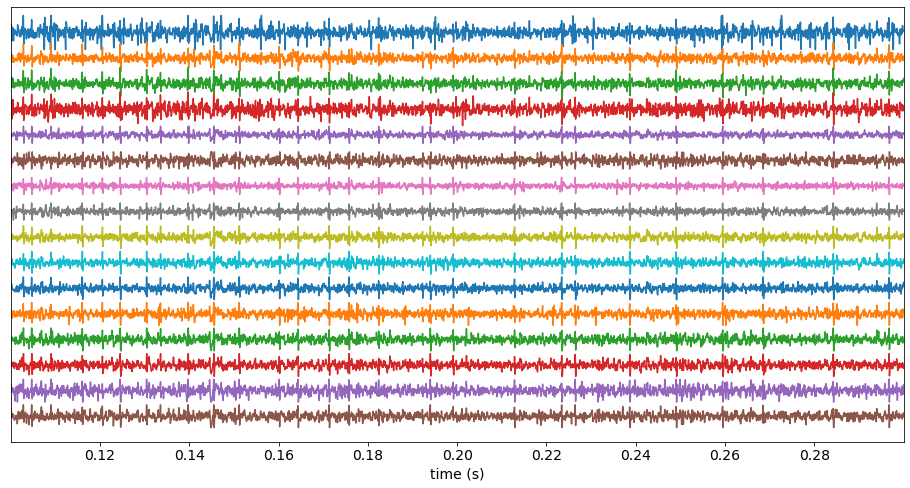

In [31]:
import spikewidgets as sw

w_ts = sw.plot_timeseries(recording, trange=[0.1, 0.3])

## 2. Read `.X` data into `spikeextractors`.

### Tetrode/stereotrode data files (“.1” to “.32”)

Data from tetrode 1 is stored in the “.1” file. Similarly, data from tetrode N is stored in file “.N”.

In unit mode, data is stored in 1 ms chunks, 200 µs and 800 µs after a threshold event. The header will contain a setting called “spike_format”. Generally, there are 216 bytes per spike, structured as 54 bytes per channel, in order by channel number (so, for tetrode 1, the channels are in the order 1, 2, 3, 4, or actually 1a, 1b, 1c, 1d in dacq2 nomenclature, etc.). The 54 bytes consist of a 4 byte time stamp (most significant byte first), then 50 8-bit samples. The ASCII header specifies you how many spikes there should be in the file (“num_spikes”), and the “timebase” of the timestamps (almost always 96 kHz, which means the 4-byte timestamp value needs to be divided by 96000 to get a time in seconds). The samples themselves are normally collected at 48 kHz (again, specified in the header).

In [9]:
from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor

recording_x = AxonaUnitRecordingExtractor(filename=set_file, noise_std=10)

print('Channel ids = {}'.format(recording_x.get_channel_ids()))
print('Num. channels = {}'.format(len(recording_x.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording_x.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording_x.get_num_frames()))
print('Channel groups = {}'.format(recording_x.get_channel_groups()))

Channel ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000 Hz
Num. timepoints = 57600
Channel groups = [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


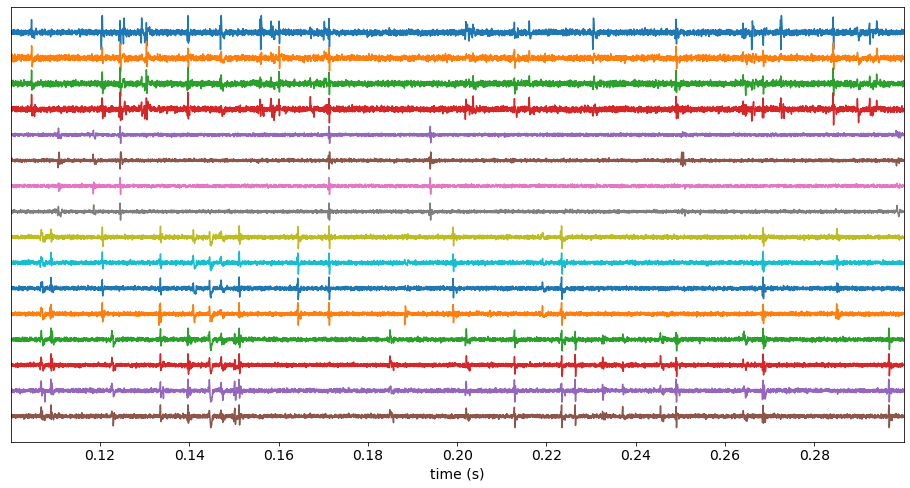

In [10]:
w_ts = sw.plot_timeseries(recording_x, trange=[0.1, 0.3])

## 3. Create spike sorting pipeline for `.bin` or `.X` data.

In [25]:
import spikeextractors as se

sorting_MS4 = se.MdaSortingExtractor(
    file_path=os.path.join(dir_name, 'mountainsort4.mda'),
    sampling_frequency=48000
)
print('Unit ids = {}'.format(sorting_MS4.get_unit_ids()))
spike_train = sorting_MS4.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_MS4.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=48000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Num. events for unit 1 = 98
Num. events for first second of unit 1 = 82


In [21]:
from pathlib import Path

nwb_dir = Path(str(dir_name) + '_no_bin') / 'nwb'

sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

## 4. Export spike sorting results from `spikeextractors` to `TINT` format.

In [41]:
set_file_new_folder = Path(set_file).parent / 'conversion_to_tint' / Path(set_file).name

print(set_file_new_folder)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/conversion_to_tint/axona_sample.set


In [42]:
from hussaini_lab_to_nwb import TintConverter

In [44]:
tint_converter = TintConverter(recording, sorting_nwb, set_file_new_folder)

In [45]:
tint_converter.write_to_tint()

Writing axona_sample.1
Writing axona_sample.2
Writing axona_sample.3
Writing axona_sample.4
Write unit labels for tetrode 0 to .cut and .clu
Write unit labels for tetrode 1 to .cut and .clu
Write unit labels for tetrode 2 to .cut and .clu
Write unit labels for tetrode 3 to .cut and .clu


## Remaining work items

- Rewrite or modify the functions directly taken from `BinConverter` or other Hussaini lab repositories (copy left license). This affects `hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms.write_tetrode()`, `hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms.get_set_header()` and `hussaini_lab_to_nwb.tint_conversion.export_spike_labels.write_to_cut_file()`.
- Test exporting to `TINT` format more thoroughly and read back in to `neo` and `spikeextractors`.
- Polish final spike sorting notebooks including writing to `TINT` for `.bin`, `.X` and `Intan`. 
- Finalize remaining open PRs
    - neo axonarawio with .X support: https://github.com/NeuralEnsemble/python-neo/pull/986
    - spikeextractors: https://github.com/SpikeInterface/spikeextractors/pull/637
    - hussaini_lab_to_nwb Tint conversion: https://github.com/catalystneuro/hussaini-lab-to-nwb/pull/2

## Future work items (out of scope?)

- Ensure `.X` data can be parsed with new `spikeinterface` API.

- Find a better solution for a continuous `analogsignal_chunk` in `axonarawio` in `neo` for `.X` data?